[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM.git/master?filepath=PySDM_tutorials/environments/box.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM/blob/master/PySDM_tutorials/environments/box.ipynb)

In [1]:
"""
clone and install PySDM dependencies in Colab
(to use GPU on Colab set hardware accelerator to 'GPU' before session start
in the "Runtime :: Change runtime type :: Hardware accelerator" menu)
"""
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('PySDM'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/PySDM.git
    %cd PySDM
    !pip install -r requirements.txt

In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/PySDM
else:
    sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [3]:
from PySDM.physics import si
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.formulae import volume

n_sd = 2 ** 17
initial_spectrum = Exponential(
    norm_factor=8.39e12, scale=1.19e5 * si.um ** 3)
sampling_range = (volume(radius=10 * si.um),
                  volume(radius=100 * si.um))


/home/edejong/.conda/envs/edjPySDM/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [8]:
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesNumberVolumeSpectrum

builder = Builder(n_sd=n_sd, backend=CPU)
environment = Box(dt=1 * si.s, dv=1e6 * si.m ** 3)
builder.set_environment(environment)
attributes = environment.init_attributes(spectral_discretisation=ConstantMultiplicity(spectrum=initial_spectrum))
builder.add_dynamic(Coalescence(kernel=Golovin(b=1.5e3 / si.s)))
products = [ParticlesVolumeSpectrum()]
core = builder.build(attributes, products)

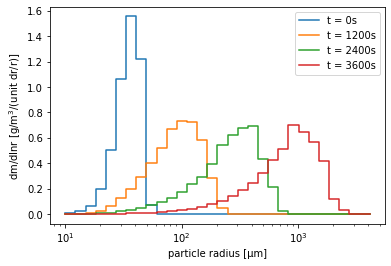

In [9]:
from PySDM.physics.constants import rho_w
from matplotlib import pyplot
import numpy as np

radius_bins_edges = np.logspace(
    np.log10(10 * si.um), np.log10(5e3 * si.um), num=32)

for step in [0, 1200, 2400, 3600]:
    core.run(step - core.n_steps)
    pyplot.step(
        x=radius_bins_edges[:-1] / si.um,
        y=core.products['dv/dlnr'].get(radius_bins_edges) * rho_w / si.g,
        where='post', label=f"t = {step}s")

pyplot.xscale('log')
pyplot.xlabel('particle radius [µm]')
pyplot.ylabel("dm/dlnr [g/m$^3$/(unit dr/r)]")
pyplot.legend()
pyplot.show()

kernel const / dv * characteristic volume * dt =

(1.5e3 / sec) / (1e6 um^3) * (1.10e5 um^3) * 1200 sec = 198,000